<a href="https://colab.research.google.com/github/twloehfelm/AI-Deep-Learning-Lab-2021/blob/main/RSNA_2021_DICOM_IN_DICOM_OUT_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table width="100%">
    <tr>
      <td align="center"><h1>Segmentation</h1></td>
    </tr>
</table>


We are going to build a generic CT segmentation tool based on the Mask RCNN network as implemented in Facebook's detectron2 library.


---


Perhaps you've heard that "DICOM is not good for CNNs, so first we'll convert it to Nifti, or PNG, or 8-bit RGB files..." Totally not true! - the problem is not DICOM, the problem is that available software tools were not designed with DICOM in mind. DICOM is actually a great way to store medical images AND segmentation masks (or probability heat maps, or regions of interest...), and with relatively minor modifications, AI libraries like detectron2 can easily learn straight from DICOM and store their predictions in DICOM.

In my opinion, sticking with DICOM would significantly lower the barrier to entry for collaboration, sharing models, and integrating with existing software and workflows.


---


The network in this notebook learns from regular DICOM and DICOM SEG objects, and produces valid DICOM SEG objects as output. It can (theoretically!) segment anything provided you have the training data. Give it DICOM with DICOM SEG segmentations of the liver and spleen, and the network will learn to segment the liver and spleen. Give it segmentations of the kidneys and gallbladder, and it will learn to segment the kidneys and gallbladder, etc.

You can produce DICOM SEG segmentations using a number of common tools - I used [ePad](https://epad.stanford.edu/) and [3D Slicer](https://www.slicer.org/) to make these segmentations. Slicer is a great option to view the output segmentations as well.


---


This notebook is based heavily on the [detectron2](https://github.com/facebookresearch/detectron2) introductory [Colab Notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) and on examples from the [highdicom python library](https://highdicom.readthedocs.io/en/latest/). Some of the CTs and liver segmentations come from the [CHAOS Grand Challenge](https://chaos.grand-challenge.org/).

UC Davis radiology residents Shan Hansra and Kate Ford contributed some of the manual organ segmentations in the training data.

# Install required packages

In [ ]:
%reload_ext autoreload
%autoreload
!pip install pyyaml==5.1 > /dev/null

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html > /dev/null
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Install a few python libraries to facilitate working with DICOM (pydicom) and DICOM SEG (highdicom)
!pip3 install -q pydicom
!pip3 install -q highdicom

In [ ]:
## You may need to restart your runtime prior to this, to let your installation take effect
import torch
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode, GenericMask

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils

# import some common libraries
import numpy as np
import cv2
import random

# Imports for liver seg
import os
from pathlib import Path
import shutil
import pydicom
from pydicom import dcmread
import pycocotools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
from highdicom.seg.utils import iter_segments
from pydicom.sr.codedict import codes
from pydicom.uid import generate_uid
from highdicom.content import AlgorithmIdentificationSequence
from highdicom.seg.content import SegmentDescription
from highdicom.content import PixelMeasuresSequence
from highdicom.seg.enum import (
  SegmentAlgorithmTypeValues,
  SegmentationTypeValues
)
from highdicom.seg.sop import Segmentation

from matplotlib.pyplot import imshow
%matplotlib inline

In [ ]:
# Download liver seg training data to root directory
!mkdir /content/pts
!wget -q https://www.dropbox.com/s/wm3gzvmk1e97n6y/dicomseg_train.zip -O /content/pts/download.zip
!unzip /content/pts/download.zip -d /content/pts > /dev/null

In [ ]:
# Clean up data folders
!rm -rf /content/pts/__MACOSX
!rm -rf /content/pts/download.zip
!rm -rf ./sample_data
ROOT_PATH = Path('/content')
[f.unlink() for f in sorted(ROOT_PATH.glob("**/.DS_Store"))]
pts_dir = ROOT_PATH/'pts'

# Prepare the dataset

We'll randomly split the available data into training (90%) and test (10%). To keep things clear, we'll move them to distinct folders called `train` and `test` but this is not necessary - you could just as well keep track of which patients are in which group.

We'll store pointers to the patient directories in two lists called `test_pts` and `train_pts` for use later. And finally, we'll delete the existing manual segmentations from the `test_pts`. This is completely unnecessary, but we'll do it just to convince you that the manual segmentations for the test set are not available to the network during training. Deleting them also makes it clearer at the end when we save the automatically generated segmentations for the `test_pts`.

In [ ]:
# Randomly split patients 90/10 into training/testing
temp_pts = [x for x in Path(pts_dir/'dicomseg_train').iterdir() if x.is_dir()]
random.seed(716)
random.shuffle(temp_pts)
idx = int(len(temp_pts)*0.9)
train_pts = temp_pts[:idx]
test_pts = temp_pts[idx:]

for test_pt in test_pts:
  dest = Path(pts_dir/'test').joinpath(test_pt.relative_to(pts_dir/'dicomseg_train'))
  shutil.move(test_pt, dest)
  

for train_pt in train_pts:
  dest = Path(pts_dir/'training').joinpath(train_pt.relative_to(pts_dir/'dicomseg_train'))
  shutil.move(train_pt, dest)

shutil.rmtree(pts_dir/'dicomseg_train')

test_pts = [x for x in Path(pts_dir/'test').iterdir() if x.is_dir()]
train_pts = [x for x in Path(pts_dir/'training').iterdir() if x.is_dir()]

# DELETE SEGMENTATION FILES FROM TEST PATIENTS to be sure they are not used/available during training!
# This step is not necessary, it is just to clearly distinguish the output segmentations from the manual segmentations
[shutil.rmtree(dir) for pt in test_pts for study in pt.iterdir() for dir in study.iterdir() if dir.name == 'segs']


In [ ]:
# Clean up some variables from the colab runtime
del idx
del temp_pts
del test_pt
del train_pt
del dest

Let's see what organs are segmented in our training data. We will scan all of the DICOM SEG files (DICOM header field Modality == 'SEG') and save a list of unique target organs (DICOM header field SegmentLabel) in a list called `categories`.

In [ ]:
seg_dirs = [dir for pt in train_pts for study in pt.iterdir() for dir in study.iterdir() if dir.name == 'segs']
seg_files = [seg_file for seg_dir in seg_dirs for seg_file in seg_dir.iterdir() if dcmread(seg_file, stop_before_pixels=True).Modality == 'SEG']
seg_datasets = tuple([dcmread(seg, force=True) for seg in seg_files])
categories = sorted(list(set([description.SegmentLabel.lower() for seg_ds in seg_datasets for frames, frame_descriptions, description in iter_segments(seg_ds)])))
print(categories)


In [ ]:
# Clean up variables from the colab runtime
del seg_dirs
del seg_files


This is one of the modifications we're making to the plain detectron2 source code. Here we define a custom mapper function that loads an image file from a dataset dictionary (which we'll define later on), applies some modest training-time image augmentations (random changes in brightness and contrast), and loads the segmentation masks. These become the input to the network.

For the image, we read the pixel_array from the DICOM file and convert it to Hounsfield units using the RescaleSlope and RescaleIntercept, also from the DICOM header. 

Remember `y = mx + b`? 

`m` = RescaleSlope

`x` = raw pixel value from pixel_array

`b` = RescaleIntercept


---


`y` = HU.

In [ ]:
def mapper(dataset_dict):
  """
  Args:
      dataset_dict (dict): Metadata of one image, in detectron2 Dataset format.

  Returns:
      dict: a format that builtin models in detectron2 accept
  """
  # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
  dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
  ds = pydicom.dcmread(dataset_dict["file_name"])
  image = ds.pixel_array
  # Convert pixel values to Hounsfield units
  image = image*ds.RescaleSlope + ds.RescaleIntercept
  image, transforms = T.apply_transform_gens([T.RandomBrightness(0.8, 1.2), T.RandomContrast(0.8, 1.2)], image)
  dataset_dict["image"] = torch.as_tensor(image.astype("float32"))

  annos = [
      utils.transform_instance_annotations(obj, transforms, image.shape[:2])
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
  ]
  instances = utils.annotations_to_instances(annos, image.shape[:2], mask_format='bitmask')
  dataset_dict["instances"] = utils.filter_empty_instances(instances)
  return dataset_dict

class DICOMSEGTrainer(DefaultTrainer):
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=mapper)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)


In [ ]:
def bbox(img):
    """Generates a bounding box from a segmentation mask
    Bounding box is given as coordinates of upper left and lower right corner
    args:
      img = boolean array of a segmentation mask
    returns:
      coordinates of upper left and lower right corner 
    """
    try:
      x,y = np.where(img)
    except ValueError:
      return None
    if x.size != 0:
      bbox = y.min(), x.min(), y.max(), x.max()
    else:
      bbox = None
    return bbox

# from fastai2 medical imaging
def windowed(px, w, l):
    """Windows a pixel_array of Houndfield units. N.B. This is only used when we are displaying the image for visual effects.
    DO NOT window the HU pixel_array when training, since windowing truncates the dynamic range of the image and causes information loss.
    args:
      px = pixel array in Houndfield units
      w = window width (HU range)
      l = window level (center point)
    returns:
      pixel_array convered to the given window/level
    """
    if type(w) == pydicom.multival.MultiValue:
      w = w[0]
    if type(l) == pydicom.multival.MultiValue:
      l = l[0]
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

def get_windowed_image(ds):
  """Helper function that takes a pydicom dataset and returns an image pixel array using the default Window settings specified in the DICOM header"""
  im = ds.pixel_array
  im = im*ds.RescaleSlope + ds.RescaleIntercept
  im = windowed(im, ds.WindowWidth, ds.WindowCenter)
  return im

def framesByRefSOPInstanceUID(refSOPInstanceUID, refSeriesInstanceUID, source_rows, source_columns, seg_datasets):
  """Helper function that takes a CT image and looks through the DICOM SEG datasets to find segmentations that apply to that CT image"""
  data = []
  for seg_ds in seg_datasets:
    if seg_ds.ReferencedSeriesSequence[0].SeriesInstanceUID == refSeriesInstanceUID:
      for frames, frame_descriptions, description in iter_segments(seg_ds):
        category = description.SegmentLabel.lower()
        found = False
        for count, frame_description in enumerate(frame_descriptions):
          if frame_description.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID == refSOPInstanceUID:
            data.append([category, frames[count].astype(np.bool)])
            found = True
        if not found:
          data.append([category, np.full((source_rows, source_columns), False)])
  return data

def show_img_array(images, columns=10, title=None):
  ncol = columns
  nrow = len(images) / ncol
  plt.figure(figsize=[ncol*3,1+(nrow*3)], dpi=300)

  gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol),
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

  plt.suptitle(title)
  
  for i, image in enumerate(images):
    ax = plt.subplot(len(images) / ncol + 1, ncol, i + 1)
    ax.imshow(image, cmap="gray")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
  
  plt.axis('off')
  
  plt.show()


This next cell is where the detectron2 DICOM magic happens. The [Dataset is the core data structure for detectron2](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html). It organizes the images, segmentations, and other metadata and holds them in a format that the model understands.

Here, we are defining a custom dataset that includes a pointer to the source DICOM file (as `record["file_name"]`), a reference to the DICOM unique identifier for the image, the SOPInstanceUID (as `record["image_id"]`), as well as bounding boxes and masks for any DICOM SEG segmentations that apply to this image utilizing the helper functions we defined above.

In [ ]:
# Used in the DatasetCatalog.register call
def get_dicomseg_dicts(train_or_val):
  """Builds a dataset_dict for detectron2
    args:
      train_or_val = string 'train' or 'val' indicating whether to return
        the training or validation dataset_dict
    returns:
      dataset_dict with each element of the training or validation dataset
    """
  if train_or_val == "train":
    pts = train_pts
  elif train_or_val == "val":
    pts = test_pts

  dataset_dicts = []
  for pt in pts:
    dcms = [x for x in pt.glob('**/*.dcm') if dcmread(x, stop_before_pixels=True).Modality != "SEG"]
    for dcm in dcms:
      record = {}
      filename = str(dcm)
      ds = dcmread(filename, stop_before_pixels=True)
      record["file_name"] = filename
      record["image_id"] = ds.SOPInstanceUID
      record["height"] = ds.Rows
      record["width"] = ds.Columns

      categories_and_masks = framesByRefSOPInstanceUID(ds.SOPInstanceUID, ds.SeriesInstanceUID, ds.Rows, ds.Columns, seg_datasets)
      objs = []
      for category, mask in categories_and_masks:
        if bbox(mask) is not None:
          obj = {
              "bbox": bbox(mask),
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": pycocotools.mask.encode(np.asarray(mask, order="F")),
              "category_id": categories.index(category),
              "is_crowd": 0
          }
          objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
  return dataset_dicts



In [ ]:
# Clear existing DatasetCatalog and then register the training and validation datasets
DatasetCatalog.clear()  
for d in ["train", "test"]:
    DatasetCatalog.register("dicomseg_" + d, lambda d=d: get_dicomseg_dicts(d))
    MetadataCatalog.get("dicomseg_" + d).set(thing_classes=categories)
dicomseg_metadata = MetadataCatalog.get("dicomseg_train")

In [ ]:
del d

# Explore
Let's stop and take a look at the organization of our data files, and dig in to DICOM SEG a little bit.

If you click on the folder icon along the left side of the colab notebook screen you should see the directory tree of the virtual machine the colab notebook is hosted on. We've been downloading files to this VM in the cells above this one, and now your directory tree should look something like this:

Fron the device root directory, the base dir for colab is /content
1.   Within /content we have a ./pts dir, and within ./pts we have ./test and ./train
2.   Each test patient (O7mzu..., OLez..., Tgwz..., xTtz...) has a `study` dir (1Uhv..) and each study has a `DICOM` directory
3.   Each training pt (0YJc...) has a `study` dir (f0Zx...) and each study has a `DICOM` directory and a `segs` directory
4.   Each `segs` directory has a `.dcm` file containing the segmentation mask in DICOM SEG format for the indicated organ [liver, rightkidney, leftadrenal, pancreas, rightadrenal, leftkidney, and spleen]


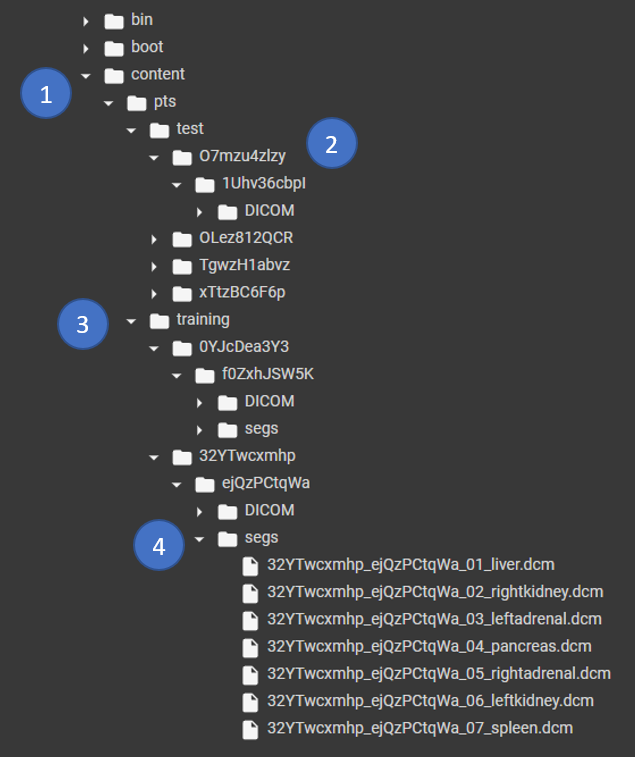

In [ ]:
pt = train_pts[0]
studies = [s for s in pt.iterdir() if s.is_dir()]
dicom_dir = studies[0]/'DICOM'
segs_dir = studies[0]/'segs'
dcms = [dcmread(dcm) for dcm in dicom_dir.iterdir()]
dcms.sort(key=lambda x: x.InstanceNumber, reverse=False)

In [ ]:
del pt
del studies
del dicom_dir

In [ ]:
images = [get_windowed_image(dcm) for dcm in dcms]
show_img_array(images)

In [ ]:
# Clear variables to save memory
del images

In [ ]:
# Show segmentations
segs = [dcmread(dcm, force=True) for dcm in segs_dir.iterdir() if dcm.is_file()]
for seg in segs:
  for frames, frame_description, description in iter_segments(seg):
    show_img_array(frames, title=description.SegmentLabel)

In [ ]:
del description
del frame_description
del frames


In [ ]:
# Choose the DICOM SEG file that contains the liver segmentation
seg = [seg for seg in segs for frames, frame_description, description in iter_segments(seg) if description.SegmentLabel == 'liver'][0]

In [ ]:
# Choose the first CT image from the standard DICOM image set
# just looking to access DICOM tags that are common among all images from this study/series, so the specific image doesn't matter
dcm = dcms[0]

In [ ]:
# Verify that the segmentation series and image series belong to the same DICOM study
seg.StudyInstanceUID == dcm.StudyInstanceUID

In [ ]:
# Verify that the segmentation file references the CT DICOM series
seg.ReferencedSeriesSequence[0].SeriesInstanceUID == dcm.SeriesInstanceUID

In [ ]:
# Verify that the segmentation file references each instance (i.e. image) from the referenced CT series
len(seg.ReferencedSeriesSequence[0].ReferencedInstanceSequence) == len(dcms)

In [ ]:
# While the segmentation file contains a reference to each image, it does not necessarily contain a pixel mask frame for each DICOM image
# The segmentation file will only contain a segmentation mask for a corresponding CT image if there is at least one target pixel present
# i.e. Frames that are completely background pixels (usually value = 0) are not discretely saved in the segmentation file
# Each frame will have a corresponding pixel_array containing the segmentation mask
seg.NumberOfFrames

In [ ]:
# The DICOM tag SegmentSequence includes metadata about the segmentation process
seg.SegmentSequence[0]

In [ ]:
# The actual pixel array of the segmentation masks are accessible in the pydicom pixel_array
# In this example, the seg file we are looking at is a liver segmentation
# The original CT scan contained 91 images of 512 x 512 resolution, and the liver was present on 31 images
# The pixel array of the liver segmentation file then will be have a shape of (31, 512, 512), or one 512x512 segmentation mask for each image that contained at least a single segmented liver pixel
np.shape(seg.pixel_array)

In [ ]:
# Sample liver mask from the middle of the segmentation stack
# Choose slice in the middle of the array
mid = int(len(seg.pixel_array)/2)
plt.imshow(seg.pixel_array[mid], cmap="binary_r", interpolation='none')

In [ ]:
# Each DICOM SEG file can contain multiple segments, and each segment can contain multiple frames
# the Highdicom library includes a function to iterate over the segments in a DICOM SEG file
# For each segment, can retrieve the frames (i.e. the segmentation mask for a specific DICOM image file) and metadata
print('segment label [# frames]\n========================')
for frames, frame_descriptions, description in iter_segments(seg):
    print('%s [%s]' % (description.SegmentLabel, len(frames)))

In [ ]:
# Each frame refers to a specific CT image in the reference study/series. The referenced SOP Instance UID is accessible like so:
ref_SOPInstanceUID = frame_descriptions[mid].DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID
ref_SOPInstanceUID

In [ ]:
# We can iterate over the CT dicoms to find the one that corresponds to the segmentation mask
# In other words, the segmentation mask we chose above is the mask for the liver on this specific CT image
ref_CT = [dcm for dcm in dcms if dcm.SOPInstanceUID == ref_SOPInstanceUID][0]
plt.imshow(get_windowed_image(ref_CT), cmap="gray")

In [ ]:
import matplotlib.colors as mcolors

colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)

# We can better show this by overlaying the segmentation mask as a semitransparent layer on the CT image
# We've defined and are using a custom color map where values == 0 are transparent so that only the target organ, not the background, is shaded
plt.imshow(get_windowed_image(ref_CT), cmap="gray")
plt.imshow(frames[mid], cmap=cmapred, vmin=0.1, alpha=0.4, interpolation='none')

In [ ]:
del dcm
del dcms
del frame_descriptions
del frames
del mid
del ref_CT
del ref_SOPInstanceUID
del seg
del segs

# Verify Data Loading
To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:
dataset_dicts = get_dicomseg_dicts("train")

In [ ]:
# Choose random images from the training dataset_dict and display image with mask overlay
images = []
for d in random.sample(dataset_dicts, 10):
    ds = dcmread(d["file_name"])
    im = get_windowed_image(ds)
    im = np.stack((im,) * 3, -1)
    im = im*255
    v = Visualizer(im[:, :, ::-1],
                   metadata=dicomseg_metadata, 
                   scale=0.8
    )
    v = v.draw_dataset_dict(d)
    #print(d["file_name"])
    images.append(v.get_image()[:, :, ::-1])
show_img_array(images, columns=5)

In [ ]:
del images
del d
del im
del ds
del description
del v

# Train

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on this abdominal organs dataset. It takes ~2 minutes to train 300 iterations on Colab.


**100** training iterations takes ~5 minutes and is used here for demo purposes. For better results set `cfg.SOLVER.MAX_ITER = 300` or more (good peformance out to at least 600 iterations)

*  100 iterations takes ~ 5 minutes
*  300 iterations takes ~ 20 minutes
*  600 iterations takes ~ 40 minutes

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dicomseg_train",)
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo


# These three SOLVER parameters are probably the best places to start tweaking to modify performance
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.1  # Can experiment with different base learning rates


######################################################
######################################################

# Primary determinant of training time
# Continues to learn out to at least 600 iterations

cfg.SOLVER.MAX_ITER = 100 #~5 minutes; 300 iterations is ~20 minutes but gives noticeably better results 

######################################################
######################################################


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this simple dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(categories)  # number of classes determined dynamically
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = len(categories)
cfg.MODEL.RETINANET.NUM_CLASSES = len(categories)
#cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 32, 64, 128, 256]]
#cfg.MODEL.PIXEL_MEAN = [485.856]
#cfg.MODEL.PIXEL_STD = [513.741]

cfg.TEST.DETECTIONS_PER_IMAGE = 20

# The following configuration settings are part of what allows detectron2 to work with (single-channel) DICOM data
# Most networks are designed to work with 3-channel RGB files (for detectron2, actually BGR)
# We change from the default _c.INPUT.FORMAT = 'BGR' to _c.INPUT.FORMAT = 'F' for 32-bit single channel floating point pixels
# We also change the default mask format from 'polygons' to 'bitmask'
cfg.INPUT.FORMAT = "F" #32-bit single channel floating point pixels
cfg.INPUT.MASK_FORMAT = "bitmask" # Needed to change this from the default "polygons"
cfg.INPUT.MAX_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TRAIN = 512
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MIN_SIZE_TRAIN = (512,)

print(cfg.dump())

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DICOMSEGTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
%reload_ext tensorboard

# Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

class DICOMSEGPredictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.
    Compared to using the model directly, this class does the following additions:
    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.
    If you'd like to do anything more fancy, please refer to its source code
    as examples to build and use the model manually.
    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.
    Examples:
    .. code-block:: python
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfg):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = build_model(self.cfg)
        self.model.eval()
        self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        
    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): a single channel image.
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            height, width = original_image.shape[:2]
            image = original_image
            image = torch.as_tensor(image.astype("float32"))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50   # set the testing threshold for this model
cfg.DATASETS.TEST = ("dicomseg_val", )
predictor = DICOMSEGPredictor(cfg)

In [ ]:
algorithm_identification = AlgorithmIdentificationSequence(
  name='DIDO_dicomseg',
  version='v0.1',
  family=codes.cid7162.ArtificialIntelligence
)

In [ ]:
GenericAnatomyColors = {
  'tissue': {'rgb': [128, 174, 128], 'DicomLab': [43802, 26566, 37721]},
  'liver': {'rgb': [221, 130, 101], 'DicomLab': [41660, 41169, 40791]},
  'pancreas': {'rgb': [249, 180, 111], 'DicomLab': [51392, 37456, 44400]},
  'spleen': {'rgb': [157, 108, 162], 'DicomLab': [34340, 40315, 27406]},
  'right kidney': {'rgb': [185, 102, 83], 'DicomLab': [34296, 40958, 39423]},
  'left kidney': {'rgb': [185, 102, 83], 'DicomLab': [34296, 40958, 39423]},
  'right adrenal': {'rgb': [249, 186, 150], 'DicomLab': [52714, 37590, 39865]},
  'left adrenal': {'rgb': [249, 186, 150], 'DicomLab': [52714, 37590, 39865]},
 }

In [ ]:
for pt in test_pts:
  studies = [s for s in pt.iterdir() if s.is_dir()]
  for s in studies:
    dcms = [dcmread(dcm) for dcm in Path(s/'DICOM').iterdir()]
    dcms.sort(key=lambda x: x.InstanceNumber, reverse=False)
    mask = {}
    series_num = dcms[0].SeriesNumber
    pixel_spacing = dcms[0].PixelSpacing
    slice_thickness = dcms[0].SliceThickness
    pixel_measures = PixelMeasuresSequence(pixel_spacing=pixel_spacing, slice_thickness=slice_thickness, spacing_between_slices=None)
    for c in categories:
      mask[c] = np.zeros(
          shape=(
              len(dcms),
              dcms[0].Rows,
              dcms[0].Columns
          ),
          dtype=bool
      )
    for num, ds in enumerate(dcms):
      im=ds.pixel_array
      im=im*ds.RescaleSlope + ds.RescaleIntercept
      outputs = predictor(im)
      predictions = outputs["instances"].to("cpu")
      pred_labels = {x: categories[x] for x in predictions.pred_classes.tolist()}
      for pred_label in pred_labels:
        organ = pred_labels[pred_label]
        preds = predictions[predictions.pred_classes == pred_label]
        if preds.has("pred_masks"):
          masks = np.asarray(preds.pred_masks)
          masks = [GenericMask(x, x.shape[0], x.shape[1]) for x in masks]
          masks = [mask.mask for mask in masks]
          if masks and not np.all((masks == 0)):
            mask[organ][num] = np.maximum.reduce(masks)
    
    for c in categories:
      if c in mask and not np.all((mask[c] == False)):
        description_segment_1 = SegmentDescription(
            segment_number=1,
            segment_label=c,
            segmented_property_category=codes.cid7150.AnatomicalStructure,
            segmented_property_type=codes.cid7166.Organ,
            algorithm_type=SegmentAlgorithmTypeValues.AUTOMATIC,
            algorithm_identification=algorithm_identification,
            tracking_uid=generate_uid(),
            tracking_id='dicomseg segmentation'
        )
        # Create the Segmentation instance
        seg_dataset = Segmentation(
          source_images=dcms,
          pixel_array=mask[c],
          segmentation_type=SegmentationTypeValues.BINARY,
          segment_descriptions=[description_segment_1],
          series_instance_uid=generate_uid(),
          series_number=series_num,
          pixel_measures=pixel_measures,
          sop_instance_uid=generate_uid(),
          instance_number=1,
          manufacturer='RSNA 2021 DIDO Segmentation',
          manufacturer_model_name='DICOM SEG Segmentation',
          software_versions='v0.1',
          device_serial_number='90210',
        )

        new_dir = Path(s/'segs')
        new_dir.mkdir(parents=True, exist_ok=True)
        fn = c.replace(' ','_')+'_DIDO_seg.dcm'
        output_path = new_dir/fn
        seg_dataset.SeriesDescription = c
        if c in GenericAnatomyColors:
          dicomLab = GenericAnatomyColors[c]['DicomLab']
        else:
          dicomLab = GenericAnatomyColors['tissue']['DicomLab']
        seg_dataset.SegmentSequence[0].add_new([0x0062, 0x000d], 'US', dicomLab)
        seg_dataset.save_as(output_path)


You should have valid DICOM SEG objects in your Colab VM file system. To make it easier to download them to your local computer so you can view them in 3D Slicer, we'll zip the test directory so there is only one file to download.

In [ ]:
!zip -r /content/DIDO_segs.zip /content/pts/test > /dev/null

You can now right-click on the DIDO_segs.zip file in the Colab root dir and download it to your local computer. Unzip it and import it into 3D Slicer to view the segmentations.

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
images = []
dataset_dicts = get_dicomseg_dicts("val")

for d in random.sample(dataset_dicts, 20): 
    ds=pydicom.dcmread(d["file_name"])
    im=ds.pixel_array
    im=im*ds.RescaleSlope + ds.RescaleIntercept
    outputs = predictor(im)
    im = windowed(im, ds.WindowWidth, ds.WindowCenter)
    im = np.stack((im,) * 3, -1)
    im=im*255
    v = Visualizer(im[:, :, ::-1],
                   metadata=dicomseg_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    images.append(v.get_image()[:, :, ::-1])
show_img_array(images, columns=3)